In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bound_funcs import * 


In [56]:
########### DATA STRUCTURE NOTES ############
# v[y,t,d]
# - contains oracle values for v[y,t,0] if they exist
# - contains values for v[y,t,1]

# Vpf_up = [y,t]
# - contains upper bound for v_y(t,0) in each entry

# Vpf_down = [y,t]
# - contains lower bound for v_y(t,0) in each entry

nrange = np.arange(0.03,.97,.1)
N = len(nrange) ** 4

v = np.zeros((2,2,2,N))
Vpf_down = np.ones((2,2,N))*.0001 #prevent division by zero
Vpf_up = np.zeros((2,2,N))

n = 0

# Vary identified terms v[y,t,1]
for a in nrange:
    for b in nrange:
        for c in nrange:
            for d in nrange:
                n += 1 
                if a + b + c + d <= 1:
                    v[0,0,1,n] = a
                    v[0,1,1,n] = b
                    v[1,0,1,n] = c
                    v[1,1,1,n] = d

# Populate unidentied terms v[y,t,0] satisfying sum v[y,t,d] = 1. 
# Not uniform sampling but that's fine for our purposes
for n in range(N): 
    s = 1-v[:,:,1,n].sum()
    ubs = np.random.rand(2,2)
    v[:,:,0,n] = (s * ubs) / ubs.sum()
    

# Populate worst case bounds Vpf_down, Vpf_up based on a constraint from p(.)   
for n in range(N): 
    rho_10 = v[0,1,0,n] + v[1,1,0,n]
    Vpf_up[0,1,n] = rho_10 
    Vpf_up[1,1,n] = rho_10 

    rho_00 = v[0,0,0,n] + v[1,0,0,n]
    Vpf_up[0,0,n] = rho_00
    Vpf_up[1,0,n] = rho_00
    
    
# Check all cells sum to one
for n in range(N):
    assert np.abs(v[:,:,:,n].sum() - 1) < .001

alpha = Vpf_up[0,0,:] - Vpf_down[0,0,:]

# Why are these greater than one? Is this an issue? 
gamma_0 = Vpf_up[0,0,:] + Vpf_up[0,1,:] + v[0,1,0,:] + v[0,1,1,:]
gamma_1 = Vpf_up[1,0,:] + Vpf_up[1,1,:] + v[1,1,0,:] + v[1,1,1,:]


# + v[0,0,1,:] + v[0,1,0] + v[0,1,1]
# gamma_1 = v[1,0,0] + v[1,0,1] + v[1,1,0] + v[1,1,1]

# alpha * v[1,1,1]

Delta_y1 = alpha*v[1,1,1]/ (gamma_1**2)
Delta_y0 = alpha*v[0,1,1]/ (gamma_0**2)


(array([9.573e+03, 9.200e+01, 9.800e+01, 9.200e+01, 5.000e+01, 5.200e+01,
        2.300e+01, 1.400e+01, 5.000e+00, 1.000e+00]),
 array([0.        , 0.02219048, 0.04438097, 0.06657145, 0.08876193,
        0.11095241, 0.1331429 , 0.15533338, 0.17752386, 0.19971434,
        0.22190483]),
 <BarContainer object of 10 artists>)

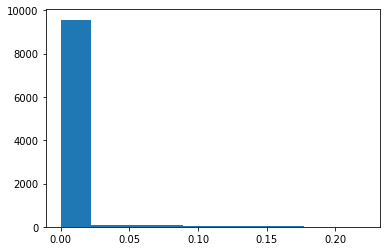

In [57]:
plt.hist(Delta_y0)

(array([ 344.,  418.,  662., 1441., 2323., 2361., 1421.,  652.,  287.,
          91.]),
 array([0.00467338, 0.10341846, 0.20216353, 0.30090861, 0.39965369,
        0.49839877, 0.59714384, 0.69588892, 0.794634  , 0.89337907,
        0.99212415]),
 <BarContainer object of 10 artists>)

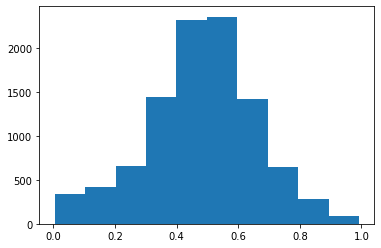

In [51]:
plt.hist(alpha)



(array([ 113.,  130.,  110.,   86.,   43., 2350., 4116., 2565.,  440.,
          47.]),
 array([0.11144717, 0.28326343, 0.45507969, 0.62689595, 0.79871221,
        0.97052847, 1.14234473, 1.31416099, 1.48597725, 1.65779351,
        1.82960977]),
 <BarContainer object of 10 artists>)

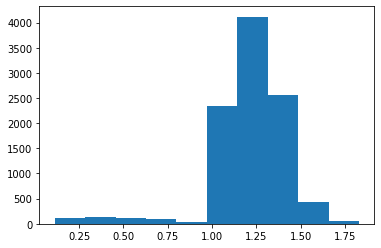

In [62]:
plt.hist(gamma_0)

In [ ]:
u = np.array([[1,0], [0, 1]])
metrics = ['m_y=1', 'm_y=0', 'm_a=0', 'm_a=1']

bounds = {
    'Rd_down': [],
    'Rd_up': [],
    'Rs_down': [],
    'Rs_up': [],
    'R_oracle': [],
    'metric': [],
    'u_00': [],
    'u_01': [],
    'u_10': [],
    'u_11': [],
    'Delta_y1':[],
    'Delta_y0':[]
}

# Check positive and negative class performance, PPV
for n in range(N):
    for metric in metrics: 
        Rd_down, Rd_up = delta_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, metric)
        Rs_down, Rs_up = standard_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, metric)
        R_oracle = oracle_regret(v[:,:,:,n], u, metric)
        
        try:
            assert Rd_down < Rd_up, f'Bound ordinality check: {Rd_down:.3} < {Rd_up:.3} violated for n={n}'
            assert Rs_down < Rs_up
            assert Rd_down-.02 <= R_oracle and R_oracle <= Rd_up+.02
            assert Rs_down-.02 <= R_oracle and R_oracle <= Rs_up+.02

        except: 
            print(f'metric: {metric}')
            print(f'Standard bounds [{Rs_down:.3}, {Rs_up:.3}]')
            print(f'Delta bounds: [{Rd_down:.3}, {Rd_up:.3}]')
            print(f'Oracle: {R_oracle:.4}')
            print()
            
        bounds['Rd_down'].append(Rd_down)
        bounds['Rd_up'].append(Rd_up)
        bounds['Rs_down'].append(Rd_down)
        bounds['Rs_up'].append(Rd_up)
        bounds['R_oracle'].append(R_oracle)
        bounds['metric'].append(metric)
        bounds['u_00'].append(u[0,0])
        bounds['u_01'].append(u[0,1])
        bounds['u_10'].append(u[1,0])
        bounds['u_11'].append(u[1,1])
        bounds['Delta_y1'].append(Delta_y1[n])
        bounds['Delta_y0'].append(Delta_y0[n])
        
        

# Check utilities over varying ranges
utils = [.01,.5,.9]
for n in range(N):
    for ua in utils:
        for ub in utils:
            for uc in utils:
                for ud in utils:
                    u = np.array([[ua,ub],[uc,ud]])
                    Rd_down, Rd_up = delta_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, 'm_u')
                    Rs_down, Rs_up = standard_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, 'm_u')
                    R_oracle = oracle_regret(v[:,:,:,n], u, 'm_u')
                    
                    try:
                        assert Rd_down <= Rd_up+.001, f'Bound ordinality check: {Rd_down:.3} < {Rd_up:.3} violated for n={n}'
                        assert Rs_down <= Rs_up+.001
                        assert Rd_down-.02 <= R_oracle and R_oracle <= Rd_up+.02
                        assert Rs_down-.02 <= R_oracle and R_oracle <= Rs_up+.02

                    except: 
                        print('N:', n)
                        print('U:', ua, ub, uc, ud)
                        print(f'Standard bounds [{Rs_down:.3}, {Rs_up:.3}]')
                        print(f'Delta bounds: [{Rd_down:.3}, {Rd_up:.3}]')
                        print(f'Oracle: {R_oracle:.4}')
                        print()
                        
                    bounds['Rd_down'].append(Rd_down)
                    bounds['Rd_up'].append(Rd_up)
                    bounds['Rs_down'].append(Rs_down)
                    bounds['Rs_up'].append(Rs_up)
                    bounds['R_oracle'].append(R_oracle)
                    bounds['metric'].append(metric)
                    bounds['u_00'].append(u[0,0])
                    bounds['u_01'].append(u[0,1])
                    bounds['u_10'].append(u[1,0])
                    bounds['u_11'].append(u[1,1])

                    bounds['Delta_y1'].append(Delta_y1[n])
                    bounds['Delta_y0'].append(Delta_y0[n])


    

In [68]:
bdf = pd.DataFrame(bounds)
bdf = bdf[bdf['metric'] == 'm_y=1']



In [69]:
bdf

,Rd_down,Rd_up,Rs_down,Rs_up,R_oracle,metric,u_00,u_01,u_10,u_11,Delta_y1,Delta_y0
0,0.000242,0.999829,0.000242,0.999829,0.568115,m_y=1,1.0,0.0,0.0,1.0,0.000000,0.000000
4,-0.496678,0.698981,-0.496678,0.698981,0.331060,m_y=1,1.0,0.0,0.0,1.0,0.015198,0.022002
8,-0.186642,0.695971,-0.186642,0.695971,0.501119,m_y=1,1.0,0.0,0.0,1.0,0.029681,0.009236
12,-0.114912,0.458781,-0.114912,0.458781,0.194582,m_y=1,1.0,0.0,0.0,1.0,0.086857,0.016325
16,-0.083009,0.429014,-0.083009,0.429014,0.223768,m_y=1,1.0,0.0,0.0,1.0,0.074358,0.012808
...,...,...,...,...,...,...,...,...,...,...,...,...
39980,0.000137,0.999630,0.000137,0.999630,0.455774,m_y=1,1.0,0.0,0.0,1.0,0.000000,0.000000
39984,0.000199,0.999799,0.000199,0.999799,0.543845,m_y=1,1.0,0.0,0.0,1.0,0.000000,0.000000
39988,0.000341,0.999859,0.000341,0.999859,0.967984,m_y=1,1.0,0.0,0.0,1.0,0.000000,0.000000
39992,0.000227,0.999821,0.000227,0.999821,0.203562,m_y=1,1.0,0.0,0.0,1.0,0.000000,0.000000


In [ ]:

n_metrics = 5
n_bins = 20
fig, axs = plt.subplots(1, len(metrics), figsize=(5*n_metrics, 5), sharey=False)
bdf['Delta_y1_b'] = (bdf['Delta_y1']*n_bins).round()/n_bins
bdf = bdf.groupby(['Delta_y1_b']).mean().reset_index()
bdf = bdf.sort_values(by='Delta_y1_b', ascending=True)

axs[0].fill_between(bdf['Delta_y1_b'], bdf['Rd_down'], bdf['Rd_up'], alpha=.5, label='$R$')
axs[0].fill_between(bdf['Delta_y1_b'], bdf['Rs_down'],bdf['Rs_up'], alpha=.5, label='$R_{\delta}$')
axs[0].plot(bdf['Delta_y1_b'], bdf[f'R_oracle'], color='k', label='Oracle')
axs[0].set_title(metric, fontsize=18)
axs[0].axhline(color='grey', alpha=.2)

In [27]:
n=2

for n in range(1000):
    u = np.array([[0.5,0],[0.5,0]])

    print(sum([(u[a,y] - u[1-a,y]) * v[y,a,1-a,n] for a in [0, 1] for y in [0, 1]]))

    print(sum([u[t,y] * (v[y,t,0,n] + v[y,t,1,n]) for t in [0, 1] for y in [0, 1]])- sum([u[d,y] * (v[y,0,d,n] + v[y,1,d,n]) for d in [0, 1] for y in [0, 1]]))
    print()

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
2.7755575615628914e-17

0.0
-2.7755575615628914e-17

0.0
0.0

0.0
0.0

0.0
0.0

0.0
-1.3877787807814457e-17

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
-6.938893903907228e-18

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
6.938893903907228e-18

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
2.7755575615628914e-17

0.0
0.0

0.0
0.0

0.0
0.0

0.0
6.938893903907228e-18

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
6.938893903907228e-18

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0
0.0

0.0

0.04387999820703936

In [30]:

for n in range(100):
    u = np.array([[1,0],[0,1]])
    Rd_down, Rd_up = delta_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, 'm_u')
    Rs_down, Rs_up = standard_bounds(v[:,:,:,n], Vpf_down[:,:,n], Vpf_up[:,:,n], u, 'm_u')
    R_oracle = oracle_regret(v[:,:,:,n], u, 'm_u')

    print(f'Standard bounds [{Rs_down:.3}, {Rs_up:.3}]')
    print(f'Delta bounds: [{Rd_down:.3}, {Rd_up:.3}]')
    print(f'Oracle: {R_oracle:.4}')
    print()

Standard bounds [-0.998, 0.998]
Delta bounds: [-0.483, 0.483]
Oracle: -0.2192

Standard bounds [-0.878, 0.878]
Delta bounds: [-0.47, 0.47]
Oracle: -0.1469

Standard bounds [-0.778, 0.778]
Delta bounds: [-0.404, 0.404]
Oracle: 0.05615

Standard bounds [-0.678, 0.678]
Delta bounds: [-0.398, 0.398]
Oracle: -0.08334

Standard bounds [-0.578, 0.578]
Delta bounds: [-0.337, 0.337]
Oracle: 0.01707

Standard bounds [-0.478, 0.478]
Delta bounds: [-0.214, 0.214]
Oracle: -0.1486

Standard bounds [-0.378, 0.378]
Delta bounds: [-0.177, 0.177]
Oracle: 0.1439

Standard bounds [-0.278, 0.278]
Delta bounds: [-0.117, 0.117]
Oracle: 0.04304

Standard bounds [-0.178, 0.178]
Delta bounds: [-0.0934, 0.0934]
Oracle: -0.07083

Standard bounds [-0.078, 0.078]
Delta bounds: [-0.0576, 0.0576]
Oracle: -0.001634

Standard bounds [-0.998, 0.998]
Delta bounds: [-0.345, 0.345]
Oracle: -0.05819

Standard bounds [-0.878, 0.678]
Delta bounds: [-0.402, 0.202]
Oracle: 0.07359

Standard bounds [-0.778, 0.578]
Delta bounds: 

In [13]:
a=0
np.clip(v[0,0,a,n] + v[1,0,a,n] + v[0,1,a,n] + v[1,1,a,n], eps, 1-eps)

0.999

In [40]:
Vpf_down

array([[[0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001]],

       [[0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001],
        [0.0001, 0.0001, 0.0001, ..., 0.0001, 0.0001, 0.0001]]])

In [41]:
np.max(Vpf_down, eps)

TypeError: 'float' object cannot be interpreted as an integer

In [12]:
Vpf_down[:,:,n]

array([[0., 0.],
       [0., 0.]])

In [11]:
Vpf_up[:,:,n]

array([[0.78001729, 0.21998271],
       [0.78001729, 0.21998271]])

In [56]:
Vpf_up[0,1,n]

0.5771274201977799

In [57]:
v[:,:,1,n].sum()

0.0

In [59]:
Vpf_up[0,0,n]

0.4228725798022203

1.0000000000000002

In [45]:

v[:,:,:,0]

array([[[0.02690634, 0.        ],
        [0.4062096 , 0.        ]],

       [[0.37933006, 0.        ],
        [0.18755399, 0.        ]]])

In [26]:
unobserved.sum()

0.8

In [ ]:
np.random.rand()

In [3]:
D = np.random.binomial(1, .8, size=1000)
A =  np.random.binomial(1, .6, size=1000)
Y = np.random.binomial(1, .8, size=1000)

v11 = ((D==1) & (A==1) & (Y==1)).mean()
v01 = ((D==1) & (A==0) & (Y==1)).mean()
w11 = ((D==1) & (A==1) & (Y==0)).mean()
w01 = ((D==1) & (A==0) & (Y==0)).mean()

rho00 = ((A==0) & (D==0)).mean()
rho01 = ((A==0) & (D==1)).mean()
rho10 = ((A==1) & (D==0)).mean()
rho11 = ((D==1) & (A==1)).mean()

v10 = ((A==1) & (D==0) & (Y==1)).mean()
v00 = ((A==0) & (D==0) & (Y==1)).mean()
w10 = ((A==1) & (D==0) & (Y==0)).mean()
w00 = ((A==0) & (D==0) & (Y==0)).mean()

v10_up = ((A==1) & (D==0)).mean()
w10_down = 0

In [58]:
v00s = np.linspace(0,rho00)
w00s = rho00 - v00s

# v10s = np.linspace(0,rho10)
# w10s = rho10 - v10s


v10s = .05 - v00s
w10s = rho10 - v10s


In [59]:
unids = pd.DataFrame({
    'v_1(0,0)': v00s,
    'v_0(0,0)': w00s,
    'v_1(1,0)': v10s,
    'v_0(1,0)': w10s
})

unids = unids[unids['v_1(1,0)'] >0]

unids

,"v_1(0,0)","v_0(0,0)","v_1(1,0)","v_0(1,0)"
0,0.000000,0.079000,0.050000,0.093000
1,0.001612,0.077388,0.048388,0.094612
2,0.003224,0.075776,0.046776,0.096224
3,0.004837,0.074163,0.045163,0.097837
4,0.006449,0.072551,0.043551,0.099449
5,0.008061,0.070939,0.041939,0.101061
6,0.009673,0.069327,0.040327,0.102673
7,0.011286,0.067714,0.038714,0.104286
8,0.012898,0.066102,0.037102,0.105898
9,0.014510,0.064490,0.035490,0.107510


In [40]:
unids = pd.DataFrame({
    'v_1(0,0)': v00s,
    'v_0(0,0)': w00s,
    'v_1(1,0)': v10s,
    'v_0(1,0)': w10s
}).T



In [41]:
v00s

array([0.        , 0.00161224, 0.00322449, 0.00483673, 0.00644898,
       0.00806122, 0.00967347, 0.01128571, 0.01289796, 0.0145102 ,
       0.01612245, 0.01773469, 0.01934694, 0.02095918, 0.02257143,
       0.02418367, 0.02579592, 0.02740816, 0.02902041, 0.03063265,
       0.0322449 , 0.03385714, 0.03546939, 0.03708163, 0.03869388,
       0.04030612, 0.04191837, 0.04353061, 0.04514286, 0.0467551 ,
       0.04836735, 0.04997959, 0.05159184, 0.05320408, 0.05481633,
       0.05642857, 0.05804082, 0.05965306, 0.06126531, 0.06287755,
       0.0644898 , 0.06610204, 0.06771429, 0.06932653, 0.07093878,
       0.07255102, 0.07416327, 0.07577551, 0.07738776, 0.079     ])